In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os

from numpy import log
from datetime import datetime
from pandas import Series

In [2]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [6]:
#make month as index number
df.set_index('Month',inplace=True)

In [7]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
#now only one column will come
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


<Axes: xlabel='Month'>

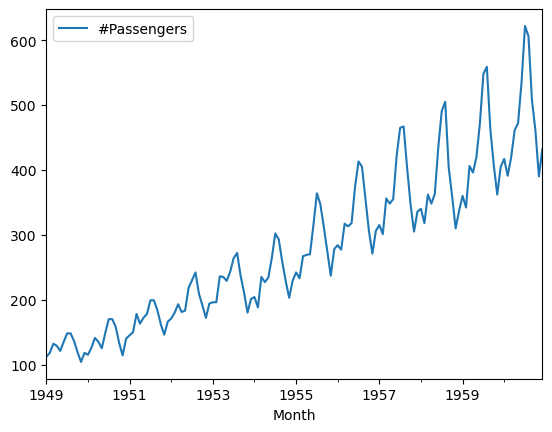

In [9]:
df.plot()

In [10]:
#its upward trend

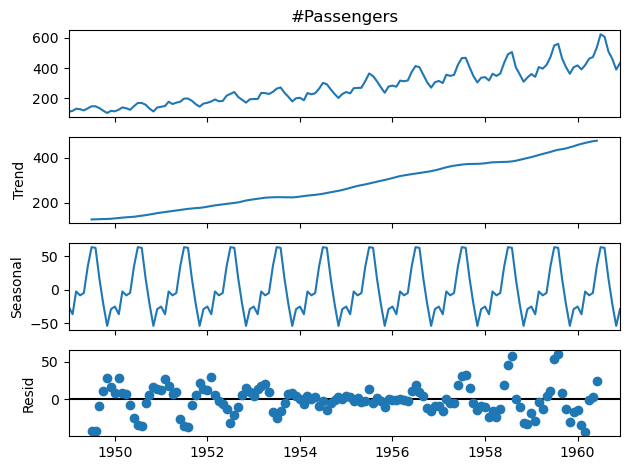

In [11]:
#Decomposition method to check all three components in the dataset
#trend,seasonality,noise

from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['#Passengers'], period=12) #so that machine can see whether every 12 months, which month is the seasonal month
decompose.plot()
plt.show()

In [12]:
# Check whether we have autocorrelation or not in the dataset (to know whether this is s TSF usecase or not)
#if value ==2, don't go by TSF, use Lin reg and if value <2 or >2 then autocorrelation exists so usecase is TSF


import statsmodels.api as sm

In [13]:
sm.stats.durbin_watson(df)
#this test is only for dependent variable
#if multiple dependent variable then check one by one for all

array([0.0121528])

In [14]:
#value is <<<<<2 , so highly positive autocorrelation found, so its a TSF problem

In [15]:
# To check whether data is stationary or non-stationary

##Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
adfuller(df['#Passengers'])

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [16]:
# 0.8153688792060482,-ADF stats test
# 0.991880243437641,- p value
#  13,- lag value
# 130,- total number of observations

In [17]:
def adf_check(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey Fuller Test")
    labels = ['ADF Test Stats', 'P-value', 'no .of lags','no. of obs']
    
    for a,b in zip(result, labels):
        print(b + " : " +str(a))
        
    if result[1] <=0.05 :
        print("Strong evidence against null hypothesis and my TS is stationary")
    else:
        print("Weak evidence against null hypothesis and my TS is non-stationary")

In [18]:
adf_check(df['#Passengers'])

Augmented Dickey Fuller Test
ADF Test Stats : 0.8153688792060482
P-value : 0.991880243437641
no .of lags : 13
no. of obs : 130
Weak evidence against null hypothesis and my TS is non-stationary


In [19]:
#To make data stationary, we have to use lag function
#see class recording for meaning of lag
df['lag'] = df['#Passengers'].shift(1)
df['1st diff'] = df['#Passengers']-df['#Passengers'].shift(1)
# 1st diff = passengers - lag

In [20]:
df.head(10)

,#Passengers,lag,1st diff
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,6.0
1949-03-01,132,118.0,14.0
1949-04-01,129,132.0,-3.0
1949-05-01,121,129.0,-8.0
1949-06-01,135,121.0,14.0
1949-07-01,148,135.0,13.0
1949-08-01,148,148.0,0.0
1949-09-01,136,148.0,-12.0


In [21]:
#check again
adf_check(df['1st diff'].dropna())

Augmented Dickey Fuller Test
ADF Test Stats : -2.8292668241699994
P-value : 0.0542132902838255
no .of lags : 12
no. of obs : 130
Weak evidence against null hypothesis and my TS is non-stationary


In [22]:
#p value is still slightly more than 0.05 , so we can do another lag

df['lag2'] = df['1st diff'].shift(1)
df['2nd diff'] = df['1st diff'] - df['lag2']

In [23]:
df.head()

,#Passengers,lag,1st diff,lag2,2nd diff
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,6.0,NaN,NaN
1949-03-01,132,118.0,14.0,6.0,8.0
1949-04-01,129,132.0,-3.0,14.0,-17.0
1949-05-01,121,129.0,-8.0,-3.0,-5.0


In [24]:
#check again
adf_check(df['2nd diff'].dropna())

Augmented Dickey Fuller Test
ADF Test Stats : -16.384231542468505
P-value : 2.7328918500142407e-29
no .of lags : 11
no. of obs : 130
Strong evidence against null hypothesis and my TS is stationary


In [25]:
#now the data is stationary

In [ ]:
#Trend : parameter : p d q
#Seasonality : param : P D Q

# d = how many times we did difference(1st and 2nd diff) , i.e 2, so d=2

In [26]:
df.head()

,#Passengers,lag,1st diff,lag2,2nd diff
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,6.0,NaN,NaN
1949-03-01,132,118.0,14.0,6.0,8.0
1949-04-01,129,132.0,-3.0,14.0,-17.0
1949-05-01,121,129.0,-8.0,-3.0,-5.0


In [ ]:
#now we calculate lag seasonality, i.e we compare the value of a year(12 months) with previous 2 years
#see the recording for excel reference if confused
#like jan 2023 vs jan 2022

In [28]:
#Check seasonality data is stationary or not

df['lag_seasonality'] = df['#Passengers'].shift(12)
df['seasonality'] = df['#Passengers']-df['#Passengers'].shift(12)
df.head(20)

,#Passengers,lag,1st diff,lag2,2nd diff,lag_seasonality,seasonality
Month,,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,6.0,NaN,NaN,NaN,NaN
1949-03-01,132,118.0,14.0,6.0,8.0,NaN,NaN
1949-04-01,129,132.0,-3.0,14.0,-17.0,NaN,NaN
1949-05-01,121,129.0,-8.0,-3.0,-5.0,NaN,NaN
1949-06-01,135,121.0,14.0,-8.0,22.0,NaN,NaN
1949-07-01,148,135.0,13.0,14.0,-1.0,NaN,NaN
1949-08-01,148,148.0,0.0,13.0,-13.0,NaN,NaN
1949-09-01,136,148.0,-12.0,0.0,-12.0,NaN,NaN


In [29]:
#check seasonal stationary
adf_check(df['seasonality'].dropna())

Augmented Dickey Fuller Test
ADF Test Stats : -3.383020726492481
P-value : 0.011551493085514952
no .of lags : 1
no. of obs : 130
Strong evidence against null hypothesis and my TS is stationary


In [30]:
#Trend and seasonality - both are stationary

#trend : d=2, p and q=?
#Seasonality : D = no of times diff =1, so D=1 P and Q =?

In [31]:
#do visualization and check whether partial autocorrelation (p/P)and autocorrelation(q/Q) exists or not

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

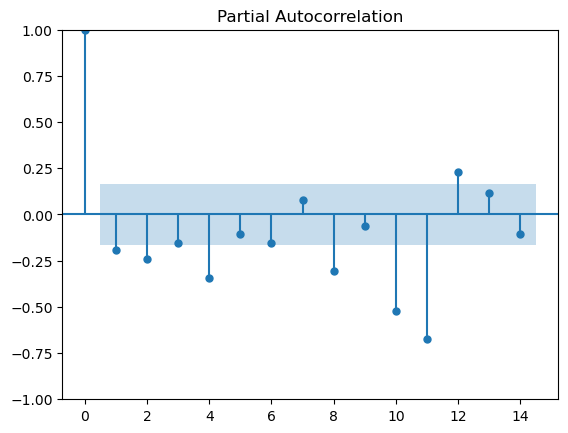

In [32]:
# Target - Trend
#d =2
#p = partial autocorrelation
# q = autocorrelation
plot_pacf(df['2nd diff'].dropna(), lags=14) #we are taking 14 months continuous data
plt.show()




In [ ]:
#see recording for interpretation
#the first long line :actual value
#any value that is above or below exceeds the shaded blue boundary m means there's partial autocorrelation 
#once we find a value inside the boundary, then we can ignore the further obs

#here we have value inside boundary after the 4th obs,so p=4

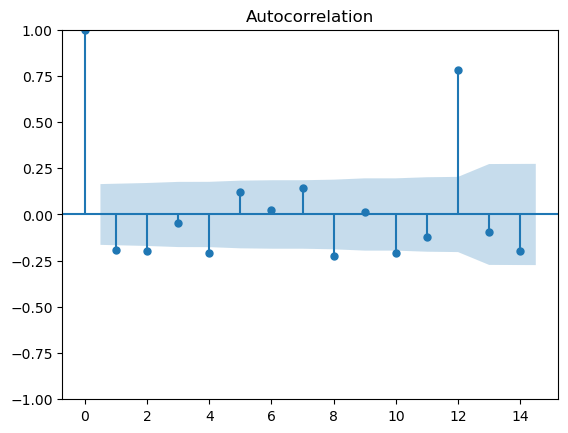

In [33]:
#now check for 1 value that is autocorrelation
# Target - Trend
#p = 4
#d =2
#q = autocorrelation
plot_acf(df['2nd diff'].dropna(), lags=14) #we are taking 14 months continuous data
plt.show()




In [ ]:
#here by same concept, q=2, after 2nd obs, the 3rd one is inside the boundary

In [ ]:
# Target - Trend
#d =2
#p = 4
#q = 2

In [ ]:
#Now check for Seasonality: P,D,Q

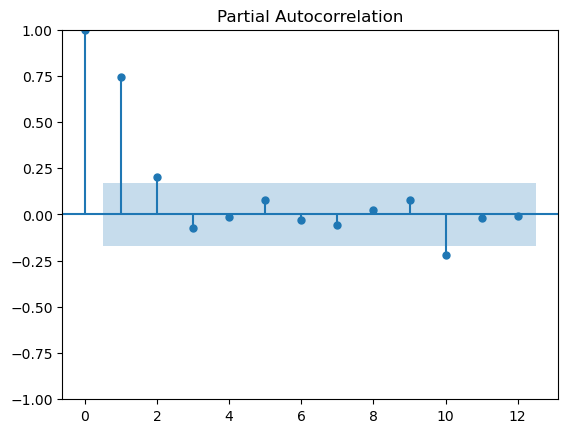

In [36]:
#Seasonality
# P=?
# D=1 calculated above
# Q =?

plot_pacf(df['seasonality'].dropna(), lags=12)
plt.show()

In [ ]:
#by same concept,
# P =2

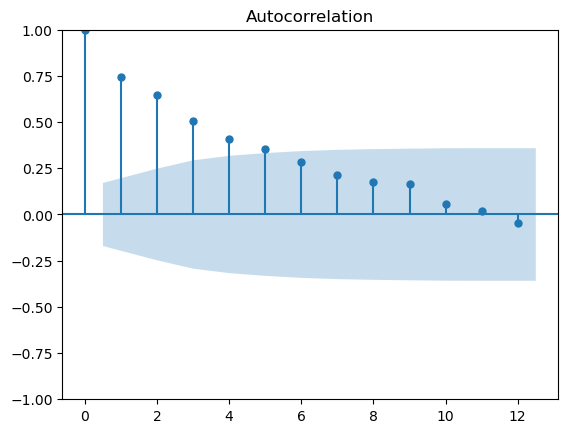

In [37]:
#check for Q (autocorrelation)
plot_acf(df['seasonality'].dropna(), lags=12)
plt.show()

In [38]:
#by same concept, Q =5

In [ ]:
#Trend
#p = 4
#d =2
#q = 2


#Seasonality
# P=2
# D=1 
# Q =5

# Building TSF - ARIMA Model
# AutoRegressive Integrated Moving Average(ARIMA)

In [40]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [41]:
model = sm.tsa.statespace.SARIMAX(df['#Passengers'], order=(4,2,2), seasonal_order=(2,1,5,12))
# SARIMA =Seasonal AIMA , X= external factor(festival reasons et)
#shift tab-> order = trend, seasonal order = seasonalty
# order=(p,d,q)
# seasonal_order=(P,D,Q,Months) if quarterly then month=4

C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
result = model.fit()

C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
print(result.summary())

                                            SARIMAX Results                                             
Dep. Variable:                                      #Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -496.736
Date:                                          Thu, 21 Dec 2023   AIC                           1021.471
Time:                                                  03:42:20   BIC                           1061.617
Sample:                                              01-01-1949   HQIC                          1037.784
                                                   - 12-01-1960                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

In [ ]:
#SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12): the model is suggesting you can take Q values as 1,2,3,4 as well

In [44]:
#AIC 1021.471, when Q : 5
#AIC ? when Q : 4
#AIC ? when Q : 3
#AIC ? when Q : 2
#AIC ? when Q : 1
#check for all these values


In [45]:
# for Q =4
model = sm.tsa.statespace.SARIMAX(df['#Passengers'], order=(4,2,2), seasonal_order=(2,1,4,12))
result = model.fit()
print(result.summary())

C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                           
Dep. Variable:                                   #Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4], 12)   Log Likelihood                -497.018
Date:                                       Thu, 21 Dec 2023   AIC                           1020.036
Time:                                               03:48:31   BIC                           1057.314
Sample:                                           01-01-1949   HQIC                          1035.183
                                                - 12-01-1960                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3748     

In [46]:
# for Q =3
model = sm.tsa.statespace.SARIMAX(df['#Passengers'], order=(4,2,2), seasonal_order=(2,1,3,12))
result = model.fit()
print(result.summary())

C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -497.157
Date:                                    Thu, 21 Dec 2023   AIC                           1018.314
Time:                                            03:48:39   BIC                           1052.724
Sample:                                        01-01-1949   HQIC                          1032.296
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3724      0.098    -14.039      0

In [47]:
# for Q =2
model = sm.tsa.statespace.SARIMAX(df['#Passengers'], order=(4,2,2), seasonal_order=(2,1,2,12))
result = model.fit()
print(result.summary())

C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, 2, 12)   Log Likelihood                -497.783
Date:                            Thu, 21 Dec 2023   AIC                           1017.566
Time:                                    03:48:45   BIC                           1049.108
Sample:                                01-01-1949   HQIC                          1030.382
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3579      0.099    -13.698      0.000      -1.552      -1.164
ar.L2         -0.4919      0.145   

In [48]:
# for Q =1
model = sm.tsa.statespace.SARIMAX(df['#Passengers'], order=(4,2,2), seasonal_order=(2,1,1,12))
result = model.fit()
print(result.summary())

C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jasmine Jena\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          #Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1], 12)   Log Likelihood                -497.782
Date:                              Thu, 21 Dec 2023   AIC                           1015.563
Time:                                      03:48:51   BIC                           1044.239
Sample:                                  01-01-1949   HQIC                          1027.215
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3590      0.097    -14.021      0.000      -1.549      -1.169
ar.L2         -0.49

In [ ]:
#AIC 1021.471, when Q : 5
#AIC 1020.036 when Q : 4
#AIC 1018.314 when Q : 3
#AIC 1017.566 when Q : 2
#AIC 1015.563 when Q : 1

#Q=1 gives best result (lesser better i guess)

#also check for BIC and rest

In [ ]:
# we have 12 years of data i.e 144 months
#we can take 11 years as training data and the last 1 year data we can predict on it

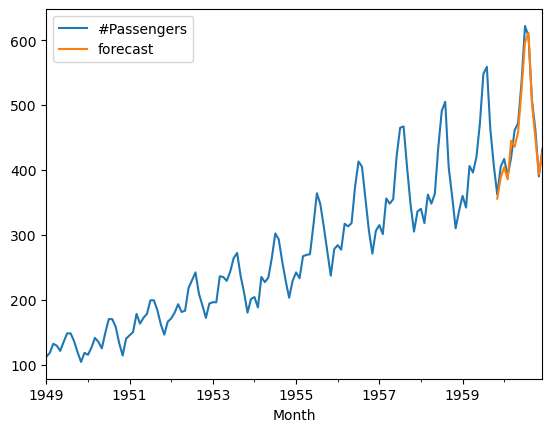

In [49]:
# Evaluate with training dataset

df['forecast'] = result.predict(start=130, end=144, dynamic =True)
df[['#Passengers', 'forecast']].plot()
plt.show()

In [ ]:
#yellow is forecasting data and its overlapping, little noisy data

In [50]:
#this was us checking the model with training data

# Predict Future(5 years)

In [51]:
from pandas.tseries.offsets import DateOffset

In [52]:
df.tail()

,#Passengers,lag,1st diff,lag2,2nd diff,lag_seasonality,seasonality,forecast
Month,,,,,,,,
1960-08-01,606,622.0,-16.0,87.0,-103.0,559.0,47.0,611.542122
1960-09-01,508,606.0,-98.0,-16.0,-82.0,463.0,45.0,503.488076
1960-10-01,461,508.0,-47.0,-98.0,51.0,407.0,54.0,448.487488
1960-11-01,390,461.0,-71.0,-47.0,-24.0,362.0,28.0,393.213074
1960-12-01,432,390.0,42.0,-71.0,113.0,405.0,27.0,426.515996


In [54]:
future_date = [df.index[-1] + DateOffset(months=x) for x in range(0,61)] #-1 means for December 1960, i.e last month
future_date

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-

In [56]:
future_dates_df = pd.DataFrame(index=future_date[1:],columns= df.columns)

In [57]:
future_dates_df

,#Passengers,lag,1st diff,lag2,2nd diff,lag_seasonality,seasonality,forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
final_data = pd.concat([df,future_dates_df])

In [59]:
final_data.head()

,#Passengers,lag,1st diff,lag2,2nd diff,lag_seasonality,seasonality,forecast
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,6.0,NaN,NaN,NaN,NaN,NaN
1949-03-01,132,118.0,14.0,6.0,8.0,NaN,NaN,NaN
1949-04-01,129,132.0,-3.0,14.0,-17.0,NaN,NaN,NaN
1949-05-01,121,129.0,-8.0,-3.0,-5.0,NaN,NaN,NaN


In [60]:
final_data.tail()

,#Passengers,lag,1st diff,lag2,2nd diff,lag_seasonality,seasonality,forecast
1965-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


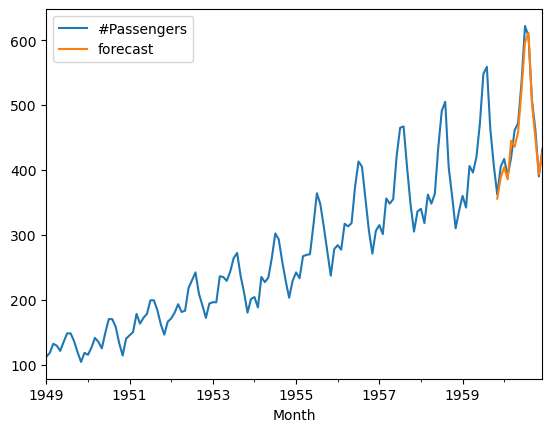

In [61]:
# Future Forecasting
final_data['forecast'] = result.predict(start=144, end=204, dynamic =True) #(204-144=60 months)
df[['#Passengers', 'forecast']].plot()
plt.show()

In [62]:
final_data.tail()

,#Passengers,lag,1st diff,lag2,2nd diff,lag_seasonality,seasonality,forecast
1965-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,892.692018
1965-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,764.950967
1965-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,701.643382
1965-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,619.606337
1965-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,670.750863


In [63]:
final_data.to_csv('final_output.csv')

# The End